### Defining simple w3 functions when uniswapper object is not avaiable

In [1]:
import os
os.environ['PROVIDER'] = 'https://goerli.prylabs.net/'

In [2]:
from web3 import Web3
from web3.middleware import geth_poa_middleware

class web3py:

    def __init__(self, endpoint=os.environ['PROVIDER']):
        self.w3 = Web3(Web3.HTTPProvider(endpoint))
        print('Connected: ', self.w3.isConnected())
        print('RPC Endpoint: ', endpoint)
        gas_price = self.w3.toWei(50, 'gwei')
        self.w3.eth.setGasPriceStrategy(gas_price)
        self.w3obj = self.w3
        
        # If gorli testnet inject middleware
        if self.w3.net.version == '5' or w3.net.version == '4':
            self.w3.middleware_onion.inject(geth_poa_middleware, layer=0)
            print('POA middleware injected')

        # Get the number of the latest block
        last_block = self.w3.eth.getBlock('latest')
        print('Latest block: ', last_block['number'])

    def get_balance(self, address):
        return self.w3.eth.getBalance(address)

    def wei_to_eth(self, value):
        return self.w3.eth.web3.fromWei(value, 'ether')

    def get_tx_receipt(self, txhash):
        return self.w3.eth.getTransactionReceipt(txhash)

    def create_address(self):
        account = self.w3.eth.account.create()
        return (account.address, account.privateKey)

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [3]:
w3py = web3py()

Connected:  True
RPC Endpoint:  https://goerli.prylabs.net/
POA middleware injected
Latest block:  3755309


In [4]:
account = w3py.create_address()

### Uniswapper functions

In [5]:
from uniswap import Uniswap

class UniSwapper:
    def __init__(self, address, private_key, entity_name, token_address=None, version=2):
        self.address = address
        self.private_key = private_key
        self.entity_name = entity_name
        self.version = version
        # Initialize uniswapper object
        self.uniswap_wrapper = Uniswap(address, private_key, version=version)  # pass version=2 to use Uniswap v2
        # Define contracts to interact with
        self.eth = "0x0000000000000000000000000000000000000000"
        self.weth = self.uniswap_wrapper.w3.toChecksumAddress("0xb4fbf271143f4fbf7b91a5ded31805e42b2208d6")
        # Set default KWH token address if not
        if token_address is None:
            self.token_address = self.uniswap_wrapper.w3.toChecksumAddress("0x78B57C213a18DF1DAbC647149902ea1966E0119C")
        else:
            self.token_address = self.uniswap_wrapper.w3.toChecksumAddress(token_address)
              
    def swap_eth_to_token(self, wei_amount, wait_tx_receipt=False):
        if wait_tx_receipt:
            tx = self.uniswap_wrapper.make_trade(self.token_address, self.eth, int(wei_amount))
            return self.uniswap_wrapper.w3.eth.waitForTransactionReceipt(tx)['blockNumber']
        else:
            return self.uniswap_wrapper.make_trade(self.token_address, self.eth, int(wei_amount))

    def swap_token_to_eth(self, wei_amount, wait_tx_receipt=False):
        if wait_tx_receipt:
            tx = self.uniswap_wrapper.make_trade(self.eth, self.token_address, wei_amount)
            return self.uniswap_wrapper.w3.eth.waitForTransactionReceipt(tx)['blockNumber']
        else:
            return self.uniswap_wrapper.make_trade(self.eth, self.token_address, wei_amount)

    def get_token_balance(self, convert_to_ether=False):
        if not convert_to_ether:
            return self.uniswap_wrapper.get_token_balance(self.token_address)
        else:
            balance = self.uniswap_wrapper.get_token_balance(self.token_address)
            return self.uniswap_wrapper.w3.eth.web3.fromWei(balance, 'ether')
    
    def get_eth_balance(self, convert_to_ether=False):
        if not convert_to_ether:
            return self.uniswap_wrapper.get_eth_balance()
        else:
            balance = self.uniswap_wrapper.get_eth_balance()
            return self.uniswap_wrapper.w3.eth.web3.fromWei(balance, 'ether')

In [6]:
u = UniSwapper(account[0], account[1], 'Community')

In [7]:
u.get_token_balance()

0

In [8]:
u.get_eth_balance()

0

In [9]:
u.entity_name

'Community'

In [10]:
address = "0xFe594E862c3ce76E192997EABFC41Afd7C975b52"
private_key = "3a8bb854c7a86d950c0d3e0b5b1bbcd3912389a95fa530e46c911fe1de099808"
account = (address, private_key)
u = UniSwapper(account[0], account[1], 'Adr')
amount = int(1/1000000 *10**18)

In [11]:
u.get_token_balance(convert_to_ether=False)

258205142498356296714384

In [12]:
u.get_token_balance(convert_to_ether=True)

Decimal('258205.142498356296714384')

### Iterate through trade data

In [13]:
import pandas as pd

In [14]:
def import_trade_data(i):
    ''' 
    This method analyses a given d3a simulation file using the input 1,2,3 as the data is structured in the /Datasets folder
    884K    ./Datasets/d3a-simulation-data/simulation2
    884K    ./Datasets/d3a-simulation-data/simulation3
    1.2M    ./Datasets/d3a-simulation-data/simulation1
    '''
    trade_df = pd.read_csv('../Datasets/d3a-simulation-data/simulation%s/Grid_trades.csv' %(i))
    f = lambda x: " ".join(x.split("T"))
    trade_df['datetime'] = trade_df['slot'].apply(f)
    trade_df.set_index(pd.to_datetime(trade_df.datetime), drop=True, inplace=True)
    trade_df.drop(columns=['slot', 'datetime'], inplace=True)
    features = ['rate [ct./kWh]', 'energy [kWh]']
    print('Unique entities trading between each other: ', trade_df.buyer.unique())
    
    # Resampling
    community_buy = trade_df[trade_df['buyer'] == 'IAA ZIP code']
    community_sell = trade_df[trade_df['seller'] == 'IAA ZIP code']
    community_buy_resampled = community_buy['energy [kWh]'].resample('15T').sum()
    community_sell_resampled = community_sell['energy [kWh]'].resample('15T').sum()
    
    merged_df = pd.merge(left=community_sell_resampled, right=community_buy_resampled, right_index=True, left_index=True, how='outer')
    merged_df.rename({'energy [kWh]_x': 'sell', 'energy [kWh]_y': 'buy'}, axis='columns', inplace=True)
    merged_df.fillna(0.0, inplace=True)
    merged_df['delta'] = merged_df['buy'] - merged_df['sell']
    merged_df['delta'].plot()

    return merged_df

Unique entities trading between each other:  ['IAA ZIP code' 'Market Maker']


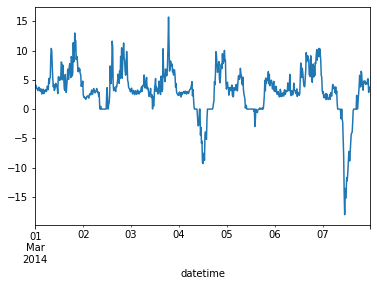

In [15]:
trade_df = import_trade_data(1)

In [16]:
trade_df.head()

,sell,buy,delta
datetime,,,
2014-03-01 00:00:00,0.0,4.060491,4.060491
2014-03-01 00:15:00,0.0,4.093684,4.093684
2014-03-01 00:30:00,0.0,3.848299,3.848299
2014-03-01 00:45:00,0.0,3.488423,3.488423
2014-03-01 01:00:00,0.0,3.509159,3.509159


In [17]:
balancing_prices = pd.read_csv('../Datasets/oracle-data/Balancing_prices_aligned_non_negative_rolling_2020-10-17-2020-11-31.csv',
                               index_col=0, parse_dates=True)

In [18]:
balancing_prices['eur/kwh'] = balancing_prices['IDAEP_GERMANY_VALUE_OP_[EUR/MWH]'] / 1000

In [19]:
balancing_prices_array = balancing_prices[0:672]['eur/kwh'].values

In [20]:
trade_df['balancing_price'] = balancing_prices_array

In [21]:
trade_df

,sell,buy,delta,balancing_price
datetime,,,,
2014-03-01 00:00:00,0.0,4.060491,4.060491,0.03509
2014-03-01 00:15:00,0.0,4.093684,4.093684,0.03356
2014-03-01 00:30:00,0.0,3.848299,3.848299,0.03508
2014-03-01 00:45:00,0.0,3.488423,3.488423,0.04054
2014-03-01 01:00:00,0.0,3.509159,3.509159,0.04815
...,...,...,...,...
2014-03-07 22:45:00,0.0,5.187038,5.187038,0.03801
2014-03-07 23:00:00,0.0,2.845826,2.845826,0.04380
2014-03-07 23:15:00,0.0,3.307886,3.307886,0.04507


### Iterate through data and swap tokens

In [22]:
import sys
sys.path.insert(0, '../')

In [23]:
import utils.uniswap_functions as uniswap_bump

1. bump prices to T0 and wait for transaction confirmation ~ 15-30s
2. start T0
3. .....
4. end T0
5. send aggregated transaction to swap ~15-30s and wait for transaction confirmation
7. bump prices to T1 and wait for transaction confirmation ~ 15-30s

In [24]:
# Create address for the community
#community_account = w3.create_address()

In [25]:
community_account = ('0xbC54e1933BBd09E278150D273FfcAa9ef0186C25', '0xea99ec9d75e84b22de0f16d4bc54e4d8894e62e8a019329ad99ba0b4c4c19c3a')

In [26]:
community_uniswapper = UniSwapper(community_account[0], community_account[1], 'Community-1')

In [27]:
community_uniswapper.get_eth_balance(convert_to_ether=True), community_uniswapper.get_token_balance(convert_to_ether=True)

(Decimal('1.004992651081481289'), Decimal('899.56657175000000256'))

In [28]:
import time

amount = 1 * 10**18

blocknumber = w3py.w3.eth.getBlock('latest')['number']
print('Current block:', blocknumber)
print('---', str(trade_df.index.min()), '-->', str(trade_df.index.max()), '---')
print()
print()

for idx, row in trade_df.iterrows():
    time_start = time.time()
    print()
    print('--', idx, '---')
    print()
    print(idx, 'Trade kWH qty:', row['delta'])
    print(idx, 'Balancing price in cents:', row['balancing_price']*100)
    print('Price balancing in LP')
    uniswap_bump.bump_price(row['balancing_price']*100)
    try:
        trade_block = community_uniswapper.swap_eth_to_token(row['delta']*amount, wait_tx_receipt=True)
        print('ETH to KWH swap happened at block:', trade_block)
        print('New price of KWH in cents:', community_uniswapper.uniswap_wrapper.get_token_token_input_price(
            community_uniswapper.token_address, community_uniswapper.weth, int(1*10**18))/10**18*400*100)
    except Exception as e:
        print('ETH to KWH swap failed')
        print(e)
    print('Time took:', time.time()-time_start)
print('Last block:', w3py.w3.eth.getBlock('latest')['number'])

Current block: 3755309
--- 2014-03-01 00:00:00 --> 2014-03-07 23:45:00 ---



-- 2014-03-01 00:00:00 ---

2014-03-01 00:00:00 Trade kWH qty: 4.060490999999999
2014-03-01 00:00:00 Balancing price in cents: 3.5090000000000003
Price balancing in LP
current price eth 9.4024799944378e-05
current price cents 3.7609919977751196
Current price of KWH too high 

Included in block: 3755311
current price eth 8.9502974594807e-05
current price cents 3.5801189837922798
Target price within range 

ETH to KWH swap happened at block: 3755312
New price of KWH in cents: 3.579570877211
Time took: 33.78056311607361

-- 2014-03-01 00:15:00 ---

2014-03-01 00:15:00 Trade kWH qty: 4.09368425
2014-03-01 00:15:00 Balancing price in cents: 3.356
Price balancing in LP
current price eth 8.9489271930275e-05
current price cents 3.579570877211
Current price of KWH too high 

Included in block: 3755313
current price eth 8.5307338075855e-05
current price cents 3.4122935230342004
Target price within range 

ETH to KWH sw

KeyboardInterrupt: 